In [9]:
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sterileprob
import sterileutil as util
import sterileU
import scipy.linalg as la
import xarray as xr

In [10]:
def prob(a, b, exp, cond, fit, m4 = 1, t14 = 0, t24= 0, t34= 0, \
	mand13 = False, vald13 = 0, manE = False, valE = 1, d14 = 0, d34 = 0, anti = False, avg = False, \
        vt23 = 0.3):
	q = util.params(exp, cond, fit)
	[m1, m2, m3, t12, t13, t23, d13, A, Ap, l, E] = \
	[q['m1'], q['m2'], q['m3'], q['t12'], q['t13'], q['t23'],\
	 q['d13'], q['A'], q['Ap'], q['l'], q['E']]
	# print(A)
	t23 = vt23
	if mand13:
		d13 = vald13
	if manE:
		E = valE
	if not anti:
		U = sterileU.PMNS(t12, t13, t23, t14, t24, t34, d13, d14, d34)
	else:
		U = sterileU.PMNS(t12, t13, t23, t14, t24, t34, d13, d14, d34).conjugate()
		A = -A
		Ap = -Ap
	# print("generated uncorrected PMNS matrix U")
	# print(U)
	Uc = U.transpose().conjugate()
	# print("generated hermitian conjugate of U")
	# print(Uc)
	# Now set the mass eigenstates diagonal matrix
	M = np.array([[m1, 0, 0, 0],
				  [0, m2, 0, 0],
				  [0, 0, m3, 0],
				  [0, 0, 0, m4]])
	# print(M)
	# Set the matter effect correction matrix
	Am = np.array([[A, 0 ,0 ,0],
				   [0, 0, 0, 0],
				   [0, 0, 0, 0],
				   [0, 0, 0, -Ap]])
	# The Hamiltonian we want to diagonalize
	temp = np.matmul(U, M)
	Heff = np.matmul(temp, Uc) + Am
	# print("generated the effected halmiltonian")
	# print(Heff)
	# Get eigenvalues and eigenvectors
	w, v = la.eig(Heff)
	# print(w)
	# effective mass matrix
	Mp = np.array([[w[0], 0, 0, 0],
				   [0, w[1], 0, 0],
				   [0, 0, w[2], 0],
				   [0, 0, 0, w[3]]])
	# print("generated effective mass matrix")
	# print(Mp)
	# effective mixing matrix
	Up = v
	Upc = v.transpose().conjugate()
	# print("generated effective PMNS patrix")
	# print(Up)


	# Now we generate the effective mass splitting matrix using Mp
	MassDif = np.array([[0j,0j,0j,0j],[0j,0j,0j,0j],[0j,0j,0j,0j],[0j,0j,0j,0j]])
	for i in range(0,4):
		for j in range(0,4):
			MassDif[i][j] = (w[i] - w[j])
	# print(MassDif)

	# Now we can calculate the oscillation probability
	U = Up
	# print(U)
	if not avg:
		def RealPartSum(i,j):
			return np.real(U[a - 1][i - 1] * U.conjugate()[b - 1][i - 1] \
								* U.conjugate()[a - 1][j - 1] * U[b - 1][j - 1]) \
								* (np.sin(MassDif[j - 1][i - 1]* 1.27 * l/E))**2
		RealPart = util.DoubleSum(1, 4, RealPartSum)
		# print(RealPart)
		RealPart *= 4
		# print(RealPart)
		# print("calculating imaginary part")
		def ImagPartSum(i, j):
			return np.imag(U[a - 1][i - 1] * U.conjugate()[b - 1][i - 1] \
								* U.conjugate()[a - 1][j - 1] * U[b - 1][j - 1]) \
								* np.sin(2 * MassDif[j - 1][i - 1]*1.27 * l/E)
		ImagPart = util.DoubleSum(1, 4, ImagPartSum)
		# print(ImagPart)
		ImagPart *= 2
		# print(ImagPart)
		res = util.KronDelta(a, b) - RealPart + ImagPart
		# print(res)
		return np.real(res)

	else:
		def RealPartSum(i,j):
			return np.real(U.conjugate()[a - 1][i - 1] * U[b - 1][i - 1] \
								* U[a - 1][j - 1] * U.conjugate()[b - 1][j - 1]) \
								* (np.sin(MassDif[j - 1][i - 1]* 1.27 * l/E))**2
		def RealPartSum4i(i):
			return np.imag(U[a - 1][i - 1] * U.conjugate()[b - 1][i - 1] \
								* U.conjugate()[a - 1][1 - 1] * U[b - 1][1 - 1]) \
								* 1/2 # np.sin(2 * MassDif[j - 1][i - 1]*1.27 * l/E)
		RealPart = util.DoubleSum(2, 4, RealPartSum) + util.Sigma(2, 4, RealPartSum4i)
		# print(util.DoubleSum(2, 4, RealPartSum))
		# print(util.Sigma(2, 4, RealPartSum4i))
		# print(RealPart)
		RealPart *= 4
		def ImagPartSum(i, j):
			return np.imag(U.conjugate()[a - 1][i - 1] * U[b - 1][i - 1] \
								* U[a - 1][j - 1] * U.conjugate()[b - 1][j - 1]) \
								* np.sin(2 * MassDif[i-1][j-1]*1.27 * l/E)
		ImagPart = util.DoubleSum(2, 4, ImagPartSum)
		# print(ImagPart)
		ImagPart *= 2
		# print(ImagPart)
		res = util.KronDelta(a, b) - RealPart + ImagPart
		# cai dan: zhe shi bai pai
		# print(res)
		return np.real(res)

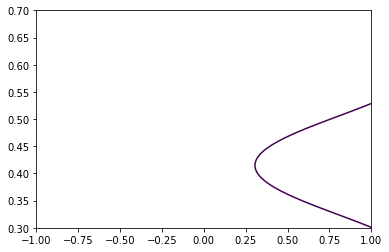

In [21]:
x = np.linspace(-1, 1, 100)
y = np.linspace(0.3, 0.7, 100)
probmatrix = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        probmatrix[i][j]= prob(2, 1, 'nova', 'NH', 'nova', m4 = 1, t14 = 0, t24 = 0,\
	 t34= 0, mand13 = True, vald13 = x[i] * np.pi,manE = False, valE = 0.9, d14 = 0, d34 = 0, \
                                            anti = False, avg = False, vt23 = np.arcsin(np.sqrt(y[j])))



t2kCI90u = 0.0675 + 1.645 * 0.0085
t2kCI90d = 0.0675 - 1.645 * 0.0085

plt.contour(x, y, probmatrix, levels = [0.0675])
plt.show()